In [108]:
from __future__ import annotations

import warnings
from pathlib import Path
from typing import Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from pmdarima import auto_arima
import matplotlib.pyplot as plt
import statsmodels.api as sm

warnings.filterwarnings("ignore")

In [ ]:
def load_energy(country: str = "New Zealand", start_year: int = 1965,
                remove_outliers: bool = True) -> pd.DataFrame:
    """Return cleaned annual energy & macro frame for *country* ≥ *start_year*."""

    cols = [
        "country", "year", "primary_energy_consumption",
        "renewables_consumption", "gdp", "population",
    ]
    df = (pd.read_csv('../data/World Energy Consumption.csv', usecols=cols)
            .query("country == @country and year >= @start_year")
            .set_index("year")
            .sort_index())

    # Interpolate GDP & population – both directions then ff/bf fill
    for col in ("gdp", "population"):
        df[col] = (df[col]
                    .interpolate(limit_direction="both")
                    .ffill()  # leading
                    .bfill())  # trailing

    # Optional outlier dampening on primary energy
    if remove_outliers:
        y = df["primary_energy_consumption"]
        pct = y.pct_change()
        mask = pct.abs() > 0.25 
        if mask.any():
            df.loc[mask, "primary_energy_consumption"] = np.nan
            df["primary_energy_consumption"] = df["primary_energy_consumption"].interpolate()

    # Exogenous growth rates
    df["gdp_growth"] = df["gdp"].pct_change().fillna(0)
    df["pop_growth"] = df["population"].pct_change().fillna(0)

    # Final sanity-check
    if df.isna().any().any():
        raise ValueError("NaNs remain after cleaning:\n" + df.isna().sum().to_string())

    return df.drop(columns="country")

In [ ]:
def fit_arima(y: pd.Series, X: pd.DataFrame) ->
    return auto_arima(
        np.log1p(y),
        exogenous=X,
        d=1,
        max_p=4,
        max_q=4,
        seasonal=False,
        with_intercept=True,      # drift term
        information_criterion="aic",
        stepwise=True,
        suppress_warnings=True,
    )


In [111]:
def rolling_cv(y: pd.Series, X: pd.DataFrame, splits: int = 5) -> Tuple[float, float]:
    tss = TimeSeriesSplit(n_splits=splits)
    maes, rmses = [], []
    for train_idx, test_idx in tss.split(y):
        m = fit_arima(y.iloc[train_idx], X.iloc[train_idx])
        pred_log = m.predict(n_periods=len(test_idx), exogenous=X.iloc[test_idx])
        pred = np.expm1(pred_log)
        truth = y.iloc[test_idx]
        maes.append(mean_absolute_error(truth, pred))
        rmses.append(np.sqrt(mean_squared_error(truth, pred)))
    return float(np.mean(maes)), float(np.mean(rmses))

In [112]:
def forecast_series(df: pd.DataFrame, target: str,
                    horizon: int = 8,
                    gdp_growth: float = 0.02,
                    pop_growth: float = 0.01) -> pd.DataFrame:

    y = df[target]
    exog_cols = ["gdp_growth", "pop_growth"]
    X = df[exog_cols]

    # Train full model
    model = fit_arima(y, X)

    last = df.iloc[-1]
    future_years = range(df.index[-1] + 1, df.index[-1] + horizon + 1)

    future_X = pd.DataFrame({
        "gdp_growth": np.full(horizon, gdp_growth),
        "pop_growth": np.full(horizon, pop_growth),
    }, index=future_years)

    log_fc, ci = model.predict(n_periods=horizon, exogenous=future_X, return_conf_int=True)
    fc = np.expm1(log_fc)

    out = pd.DataFrame({
        "year": future_years,
        "forecast": fc.round(2),
        "lower_95": np.expm1(ci[:, 0]).round(2),
        "upper_95": np.expm1(ci[:, 1]).round(2),
    })

    # --- Plot ----------------------------------------------------------------
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, y, label="Historical", lw=2)
    plt.plot(out["year"], out["forecast"], "r--o", label="Forecast")
    plt.fill_between(out["year"], out["lower_95"], out["upper_95"], color="gray", alpha=.25)
    plt.title(f"New Zealand – {target.replace('_',' ').title()} (ARIMA {model.order})")
    plt.ylabel("TWh")
    plt.grid(True)
    plt.legend(); plt.tight_layout(); plt.show()

    return out

In [ ]:
def holdout_evaluate(df: pd.DataFrame, target: str,
                     horizon: int = 5,
                     gdp_growth: float = 0.02,
                     pop_growth: float = 0.01) -> pd.DataFrame:

    train = df.iloc[:-horizon]
    test  = df.iloc[-horizon:]
    y_train, X_train = train[target], train[["gdp_growth", "pop_growth"]]
    y_test,  X_test  =  test[target],  test[["gdp_growth", "pop_growth"]]

    model = fit_arima(y_train, X_train)
    log_fc, ci = model.predict(n_periods=horizon, exogenous=X_test,
                               return_conf_int=True)
    fc    = np.expm1(log_fc)
    lower = np.expm1(ci[:, 0])
    upper = np.expm1(ci[:, 1])

    mae   = mean_absolute_error(y_test, fc)
    rmse  = np.sqrt(mean_squared_error(y_test, fc))
    mape  = np.mean(np.abs((y_test - fc) / y_test)) * 100
    smape = 100/len(fc) * np.sum(2*np.abs(fc - y_test) /
                                 (np.abs(y_test) + np.abs(fc)))
    coverage = np.mean((y_test >= lower) & (y_test <= upper)) * 100

    print(f"Horizon: {horizon}")
    print(f"MAE: {round(mae, 2)}")
    print(f"RMSE: {round(rmse, 2)}")
    print(f"MAPE (%): {round(mape, 2)}")
    print(f"SMAPE (%): {round(smape, 2)}")
    print(f"CI Coverage (%): {round(coverage, 1)}")
    print(f"AIC: {round(model.aic(), 1)}")
    print(f"BIC: {round(model.bic(), 1)}")
    
    return pd.DataFrame([{
        "Horizon": horizon,
        "MAE": round(mae, 2),
        "RMSE": round(rmse, 2),
        "MAPE (%)": round(mape, 2),
        "SMAPE (%)": round(smape, 2),
        "CI Coverage (%)": round(coverage, 1),
        "AIC": round(model.aic(), 1),
        "BIC": round(model.bic(), 1),
    }])


In [ ]:
def plot_residual_diagnostics(model, y: pd.Series, X: pd.DataFrame):
    resid = np.expm1(model.resid())  # back-transform
    fig, ax = plt.subplots(2, 2, figsize=(12, 8))
    sm.graphics.tsa.plot_acf(resid, lags=20, ax=ax[0,0])
    sm.graphics.tsa.plot_pacf(resid, lags=20, ax=ax[0,1])
    sm.qqplot(resid, line="s", ax=ax[1,0])
    ax[1,0].set_title("Q-Q plot")
    resid.plot(kind="kde", ax=ax[1,1])
    ax[1,1].set_title("Density")

    plt.suptitle("Residual diagnostics"); plt.tight_layout()

    lb = sm.stats.acorr_ljungbox(resid, lags=[10, 15, 20], return_df=True)
    print("\nLjung-Box (null: no autocorrelation)\n", lb.round(3))

In [ ]:
def evaluate_model(df: pd.DataFrame, target: str,
                   horizon: int = 5,
                   gdp_growth: float = 0.02,
                   pop_growth: float = 0.01):

    metrics = holdout_evaluate(df, target, horizon, gdp_growth, pop_growth)
    print("\nHold-out back-test metrics:\n", metrics.to_string(index=False))

    # Forecast to display side-by-side with actual
    train = df.iloc[:-horizon]
    test  = df.iloc[-horizon:]
    model = fit_arima(train[target], train[["gdp_growth", "pop_growth"]])
    fc = np.expm1(model.predict(horizon,
                                exogenous=test[["gdp_growth", "pop_growth"]]))
    plt.figure(figsize=(10,5))
    plt.plot(df.index, df[target], label="Actual", lw=2)
    plt.plot(test.index, fc, "r--o", label="Forecast")
    plt.title(f"Back-test ({horizon}-year horizon)")
    plt.legend(); plt.grid(True); plt.show()

    # Residual checks
    plot_residual_diagnostics(model, train[target], train[["gdp_growth","pop_growth"]])

In [116]:
df = load_energy()
mae, rmse = rolling_cv(df["primary_energy_consumption"], df[["gdp_growth", "pop_growth"]])
print(f"Rolling CV  MAE = {mae:.2f} TWh   RMSE = {rmse:.2f} TWh")

Rolling CV  MAE = 20.28 TWh   RMSE = 23.55 TWh


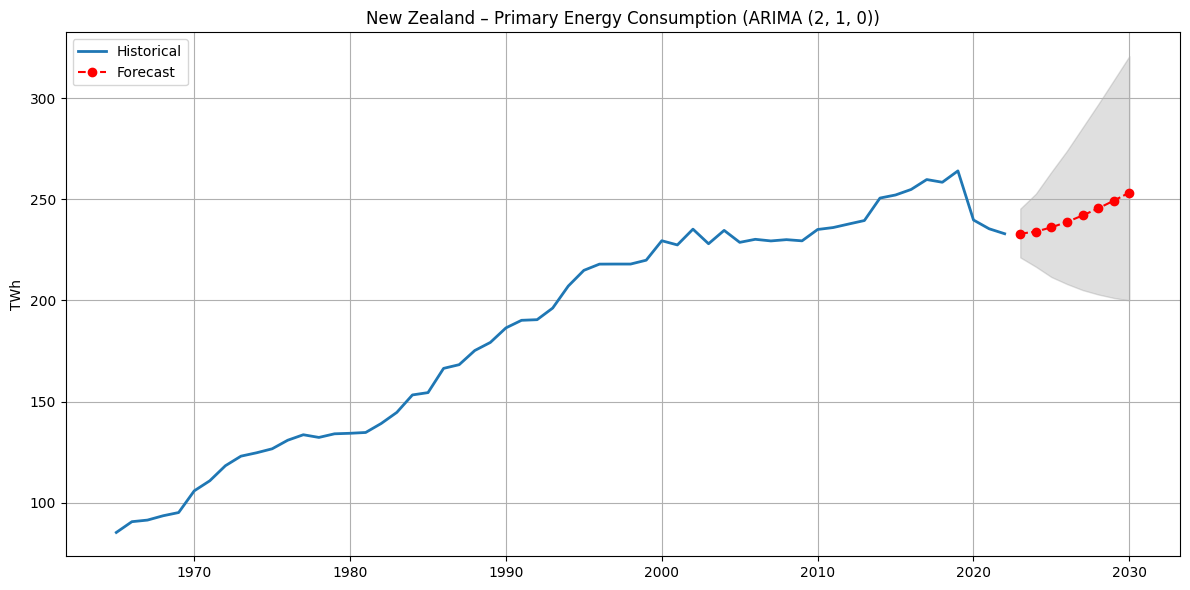


Primary-energy forecast (TWh):
  year  forecast  lower_95  upper_95
 2023    233.05    221.31    245.42
 2024    234.07    216.71    252.81
 2025    236.19    211.60    263.63
 2026    238.86    208.14    274.08
 2027    242.06    205.16    285.57
 2028    245.57    202.98    297.06
 2029    249.38    201.26    308.94
 2030    253.37    200.02    320.89


In [117]:
fc_primary = forecast_series(df, "primary_energy_consumption", horizon=8)
print("\nPrimary-energy forecast (TWh):\n", fc_primary.to_string(index=False))


Horizon: 5
MAE: 29.24
RMSE: 35.46
MAPE (%): nan
SMAPE (%): 0.0
CI Coverage (%): 40.0
AIC: -238.3
BIC: -230.5

Hold-out back-test metrics:
  Horizon   MAE  RMSE  MAPE (%)  SMAPE (%)  CI Coverage (%)    AIC    BIC
       5 29.24 35.46       NaN        0.0             40.0 -238.3 -230.5


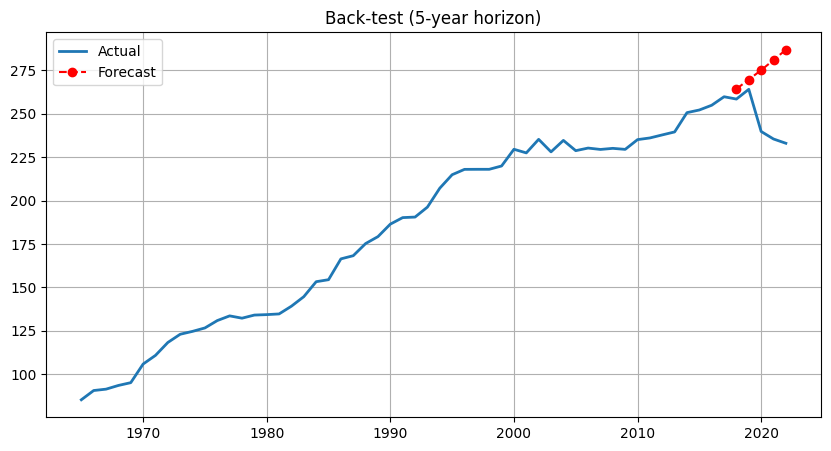


Ljung-Box (null: no autocorrelation)
     lb_stat  lb_pvalue
10    0.003        1.0
15    0.012        1.0
20    0.029        1.0


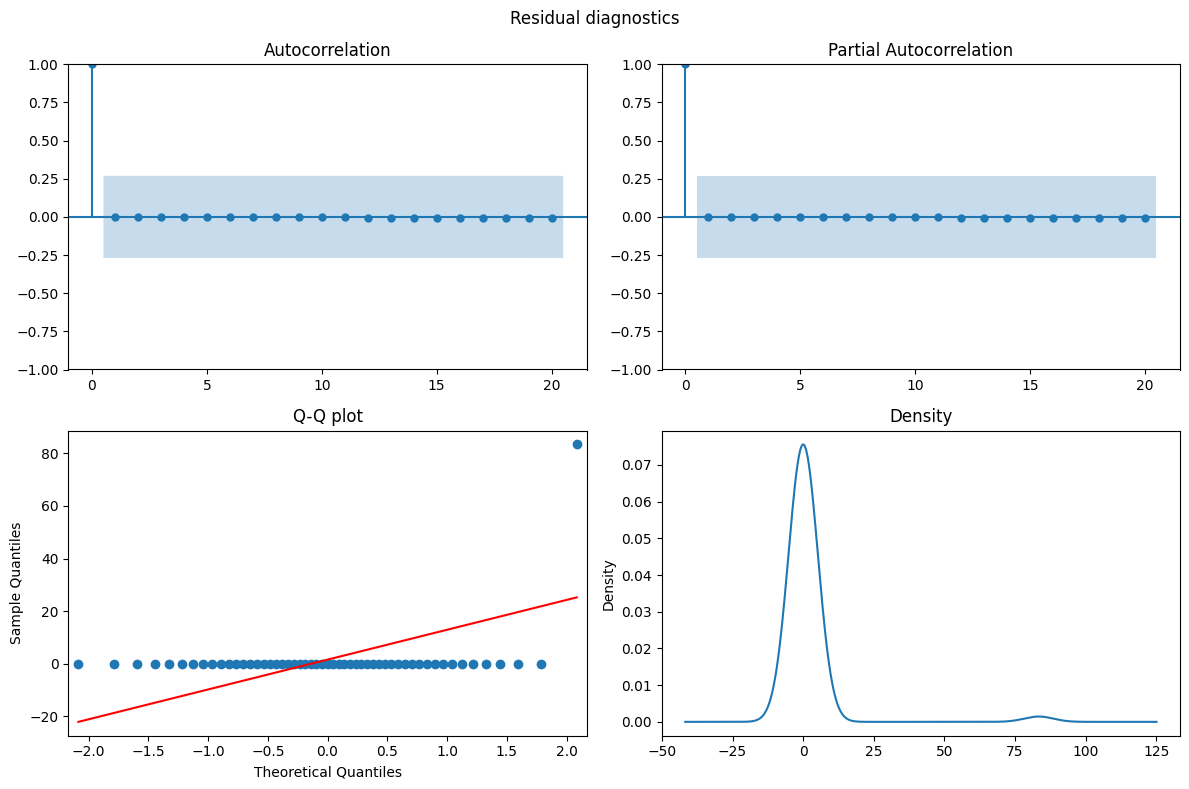

In [118]:
evaluate_model(df, "primary_energy_consumption", horizon=5)